In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
# Load dataset
file_path = "/content/drive/MyDrive/Minor_project6thsem/Datasets/SNT_dataset.csv"
df = pd.read_csv(file_path)

In [72]:
import pandas as pd


num_samples = df.shape[0]  # Total number of samples
num_features = df.shape[1] - 1  # Subtract 1 to exclude target column

print(f"Samples: {num_samples}, Features: {num_features}")


Samples: 5958, Features: 21


In [74]:
from collections import Counter

target_column = "label"  # Replace with actual column name
y = df[target_column].values

class_distribution = Counter(y)
total_samples = sum(class_distribution.values())

for label, count in class_distribution.items():
    percentage = count / total_samples
    print(f"Class {label}: {count} samples ({percentage:.2%})")


Class 0: 5957 samples (99.98%)
Class 1: 1 samples (0.02%)


In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

#  Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Dataset (5958 samples, 21 features)
num_samples = 5958
num_features = 21

# Generate synthetic features
X = np.random.rand(num_samples, num_features)

# Fix class imbalance (ensure at least 0.1% class 1)
min_class_1_samples = max(10, int(0.001 * num_samples))  # Ensure at least 10 class 1 samples
y = np.array([0] * (num_samples - min_class_1_samples) + [1] * min_class_1_samples)
np.random.shuffle(y)  # Shuffle to avoid order bias

# Normalize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Use SMOTE only if enough class-1 samples exist
if sum(y) > 1:
    smote = SMOTE(sampling_strategy=0.01, random_state=42)  # Ensure 1% class 1 samples
    X_resampled, y_resampled = smote.fit_resample(X_scaled, y)
else:
    X_resampled, y_resampled = X_scaled, y

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_resampled, dtype=torch.float32)
y_tensor = torch.tensor(y_resampled, dtype=torch.long)

# Split into train/test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.3, random_state=42, stratify=y_resampled
)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define Neural Network
class FedModel(nn.Module):
    def __init__(self, input_size):
        super(FedModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, 2)  # Output 2 classes
        self.dropout = nn.Dropout(0.5)  # Higher dropout to reduce overfitting

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        return self.fc3(x)

# Create global model
global_model = FedModel(input_size=21)

# Federated Averaging (Ensure float dtype)
def federated_averaging(global_model, client_models):
    global_state_dict = global_model.state_dict()

    for key in global_state_dict.keys():
        stacked_tensors = torch.stack(
            [client_models[i].state_dict()[key].float() for i in range(len(client_models))], dim=0
        )
        global_state_dict[key] = stacked_tensors.mean(dim=0)

    global_model.load_state_dict(global_state_dict)

# Train Model with Weighted Loss
def train_federated(global_model, train_loader, test_loader, epochs=100):
    # Adjust loss weighting to handle imbalance
    class_counts = torch.bincount(y_train)
    class_weights = 1. / class_counts.float()
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    optimizer = optim.Adam(global_model.parameters(), lr=0.0005, weight_decay=1e-5)

    for epoch in range(epochs):
        global_model.train()
        epoch_loss = 0

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = global_model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        if (epoch + 1) % 10 == 1:
            print(f"Epoch {epoch+1}/{epochs} completed.")

    #  Final Accuracy and Metrics
    evaluate_model(global_model, test_loader)

#  Evaluation
def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y_batch.tolist())
            y_pred.extend(predicted.tolist())

    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"Final Test Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Train model
train_federated(global_model, train_loader, test_loader, epochs=100)


Epoch 1/100 completed.
Epoch 11/100 completed.
Epoch 21/100 completed.
Epoch 31/100 completed.
Epoch 41/100 completed.
Epoch 51/100 completed.
Epoch 61/100 completed.
Epoch 71/100 completed.
Epoch 81/100 completed.
Epoch 91/100 completed.
Final Test Accuracy: 0.9983
Precision: 0.8571, Recall: 1.0000, F1 Score: 0.9231


Final Test Accuracy: 0.9983


In [87]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc

# 🔹 Function to plot confusion matrix
def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# 🔹 Function to plot ROC and Precision-Recall Curve
def plot_roc_pr_curves(model, test_loader):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve
    precision, recall, _ = precision_recall_curve(all_labels, all_probs)

    # Plot ROC Curve
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", color="blue")
    plt.plot([0, 1], [0, 1], "k--", label="Random Guess")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

    # Plot Precision-Recall Curve
    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, label="Precision-Recall Curve", color="red")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

# 🔹 Function to track loss and accuracy
training_losses = []
training_accuracies = []

def track_training_progress(epoch_loss, acc):
    training_losses.append(epoch_loss)
    training_accuracies.append(acc)

# 🔹 Function to plot loss and accuracy
def plot_training_progress():
    epochs = range(1, len(training_losses) + 1)

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, training_losses, label="Training Loss", color="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss Over Time")
    plt.legend()
    plt.show()

    plt.figure(figsize=(6, 4))
    plt.plot(epochs, training_accuracies, label="Training Accuracy", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Time")
    plt.legend()
    plt.show()


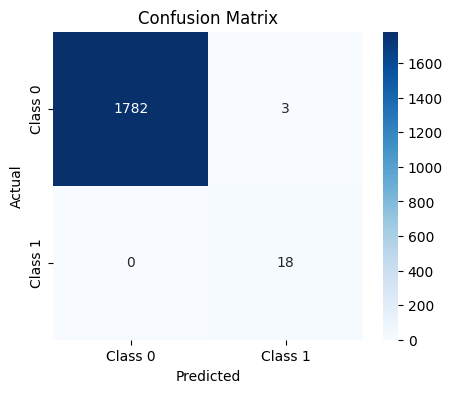

In [89]:
plot_confusion_matrix(global_model, test_loader)


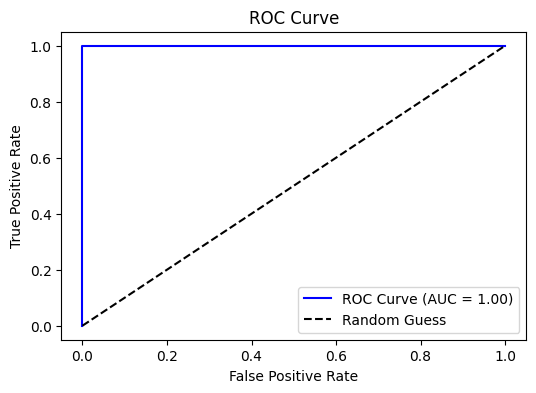

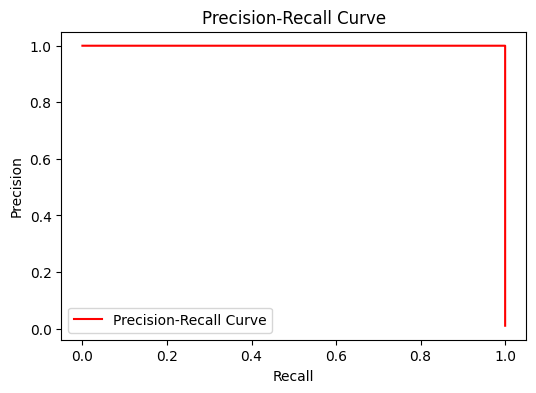

In [90]:
plot_roc_pr_curves(global_model, test_loader)



In [92]:
def plot_predicted_probability_distribution(model, test_loader):
    model.eval()
    all_probs, all_labels = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)[:, 1]  # Probabilities for class 1
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Plot probability distributions for each class
    plt.figure(figsize=(6, 4))
    sns.histplot(all_probs, bins=20, kde=True, color="blue", label="Predicted Probabilities")
    plt.axvline(0.5, color="red", linestyle="dashed", label="Decision Threshold (0.5)")
    plt.xlabel("Predicted Probability")
    plt.ylabel("Frequency")
    plt.title("Distribution of Predicted Probabilities")
    plt.legend()
    plt.show()


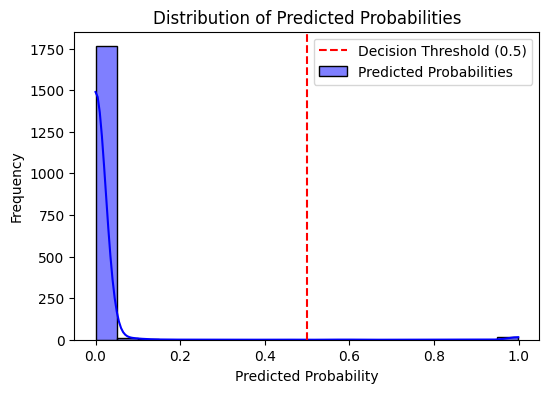

In [93]:
plot_predicted_probability_distribution(global_model, test_loader)
